<a href="https://colab.research.google.com/github/atikhasan007/Scikit-learn/blob/main/liver%20dataset%20predic%20ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mdrifaturrahman33/levir-cd-change-detection")

print("Path to dataset files:", path)

100%|██████████| 3.52G/3.52G [00:35<00:00, 106MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mdrifaturrahman33/levir-cd-change-detection/versions/1


**Custom datasets and Dataloaders**

In [11]:
import json, os, torch, cv2, numpy as np, albumentations as A
from PIL import Image; from matplotlib import pyplot as plt
from glob import glob; from PIL import ImageFile
from torch.utils.data import random_split, Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
ImageFile.LOAD_TRUNCATED_IMAGES = True

class CustomSegmentationDataset(Dataset):

    def __init__(self, root, data_type, transformations = None):

        im_path_pattern = f"{root}/{data_type}/B/*.png"
        gt_path_pattern = f"{root}/{data_type}/label/*.png"

        print(f"Searching for images in: {im_path_pattern}")
        print(f"Searching for labels in: {gt_path_pattern}")

        self.im_paths = sorted(glob(im_path_pattern))
        self.gt_paths = sorted(glob(gt_path_pattern))

        print(f"Found {len(self.im_paths)} image files.")
        print(f"Found {len(self.gt_paths)} label files.")


        self.transformations = transformations
        self.n_cls = 2

        assert len(self.im_paths) == len(self.gt_paths), f"Number of images ({len(self.im_paths)}) and labels ({len(self.gt_paths)}) do not match."

    def __getitem__(self, idx):

        im, gt = self.get_im_gt(self.im_paths[idx], self.gt_paths[idx])

        if self.transformations: im, gt = self.apply_transformations(im, gt)

        return im, (gt / 255.).int()

    def get_im_gt(self, im_path, gt_path): return self.read_im(im_path, gray = True), self.read_im(gt_path, gray = False)

    def read_im(self, path, gray = None): return cv2.cvtColor(cv2.imread(path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB) if gray else cv2.cvtColor(cv2.imread(path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2GRAY)

    def __len__(self): return len(self.im_paths)

    def apply_transformations(self, im, gt): transformed = self.transformations(image = im, mask = gt); return transformed["image"], transformed["mask"]

def get_dls(root, transformations, bs, ns = 4):

    tr_ds   = CustomSegmentationDataset(root = root,  data_type = "train", transformations = transformations)
    n_cls   = tr_ds.n_cls
    tr_len  = int(len(tr_ds) * 0.9);
    tr_ds, val_ds = random_split(dataset = tr_ds, lengths = [tr_len, len(tr_ds) - tr_len])
    test_ds = CustomSegmentationDataset(root = root,  data_type = "test",  transformations = transformations)

    print(f"\nThere are {len(tr_ds)} number of images in the train set")
    print(f"There are {len(val_ds)} number of images in the validation set")
    print(f"There are {len(test_ds)} number of images in the test set\n")

    # Get dataloaders
    tr_dl   = DataLoader(dataset = tr_ds, batch_size = bs, shuffle = True, num_workers = ns)
    val_dl  = DataLoader(dataset = val_ds, batch_size = bs, shuffle = False, num_workers = ns)
    test_dl = DataLoader(dataset = test_ds, batch_size = 1, shuffle = False, num_workers = ns)

    return tr_dl, val_dl, test_dl, n_cls

root = "/root/.cache/kagglehub/datasets/mdrifaturrahman33/levir-cd-change-detection/versions/1/LEVIR-CD+"
mean, std, im_h, im_w = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 256, 256
trans = A.Compose( [A.Resize(im_h, im_w), A.Normalize(mean = mean, std = std), ToTensorV2(transpose_mask = True) ], is_check_shapes = False)
tr_dl, val_dl, test_dl, n_cls = get_dls(root = root, transformations = trans, bs = 16)

Searching for images in: /root/.cache/kagglehub/datasets/mdrifaturrahman33/levir-cd-change-detection/versions/1/LEVIR-CD+/train/B/*.png
Searching for labels in: /root/.cache/kagglehub/datasets/mdrifaturrahman33/levir-cd-change-detection/versions/1/LEVIR-CD+/train/label/*.png
Found 637 image files.
Found 637 label files.
Searching for images in: /root/.cache/kagglehub/datasets/mdrifaturrahman33/levir-cd-change-detection/versions/1/LEVIR-CD+/test/B/*.png
Searching for labels in: /root/.cache/kagglehub/datasets/mdrifaturrahman33/levir-cd-change-detection/versions/1/LEVIR-CD+/test/label/*.png
Found 348 image files.
Found 348 label files.

There are 573 number of images in the train set
There are 64 number of images in the validation set
There are 348 number of images in the test set



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


**Data visualization**

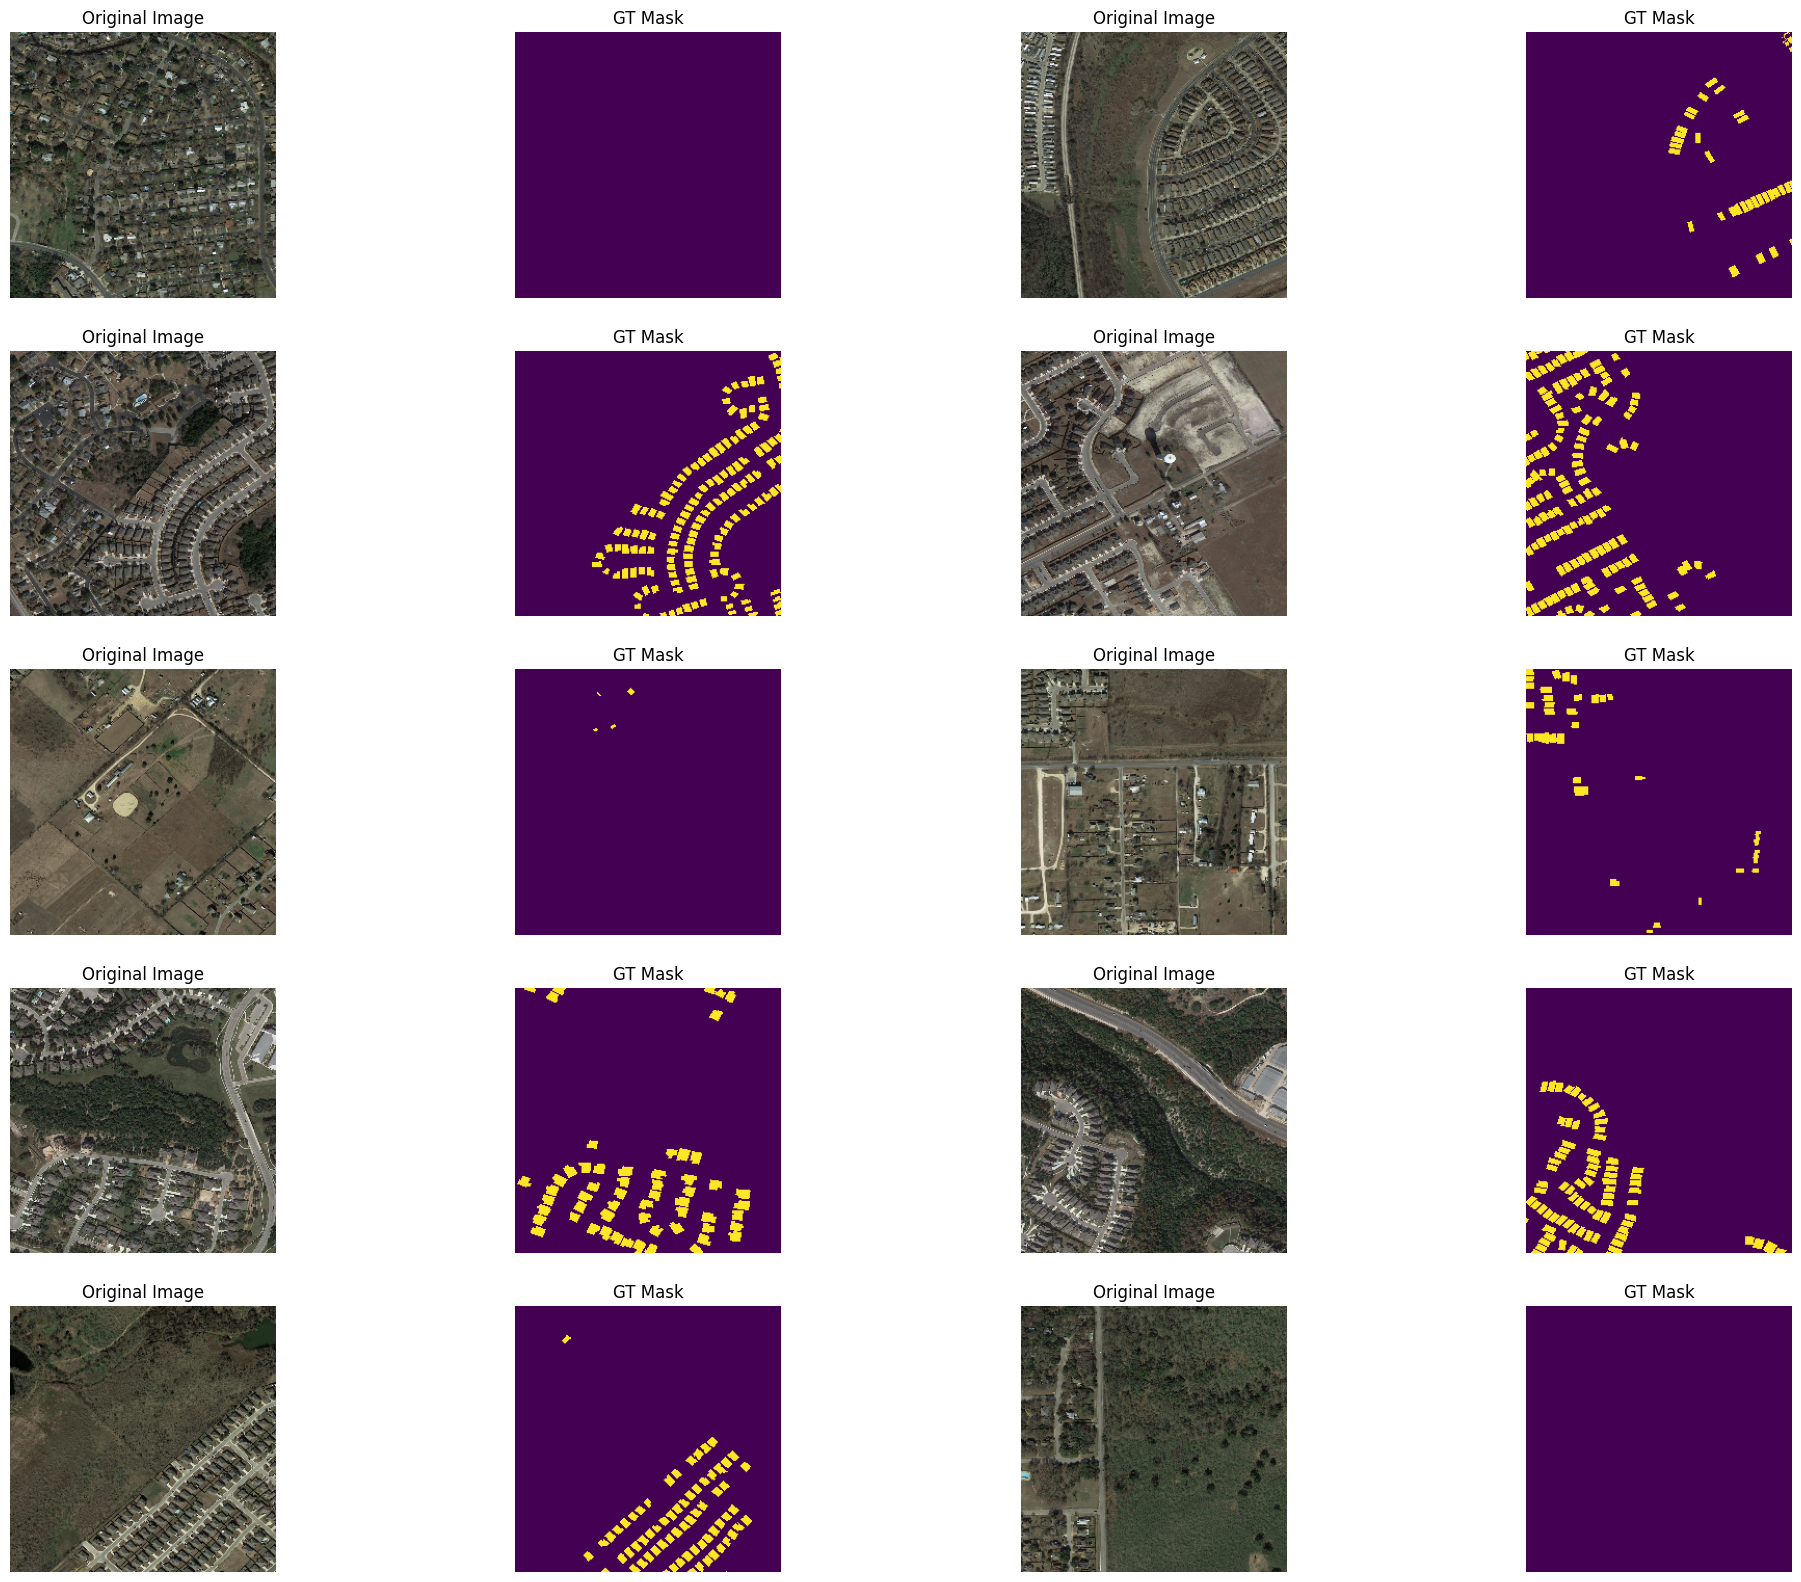

In [12]:
import random
from torchvision import transforms as tfs

def tn_2_np(t):
    invTrans = tfs.Compose([ tfs.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                tfs.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]) ])

    rgb = True if len(t) == 3 else False

    return (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8) if rgb else (t*255).detach().cpu().numpy().astype(np.uint8)

def plot(rows, cols, count, im, gt = None, title = "Original Image"):

    plt.subplot(rows, cols, count)
    plt.imshow(tn_2_np(im.squeeze(0).float())) if gt else plt.imshow(tn_2_np(im.squeeze(0)))
    plt.axis("off"); plt.title(title)

    return count + 1

def visualize(ds, n_ims):

    plt.figure(figsize = (25, 20))
    rows = n_ims // 4; cols = n_ims // rows
    count = 1
    indices = [random.randint(0, len(ds) - 1) for _ in range(n_ims)]

    for idx, index in enumerate(indices):

        if count == n_ims + 1: break
        im, gt = ds[index]

        # First Plot
        count = plot(rows, cols, count, im = im)

        # Second Plot
        count = plot(rows, cols, count, im = gt, gt = True, title = "GT Mask")

visualize(tr_dl.dataset, n_ims = 20)

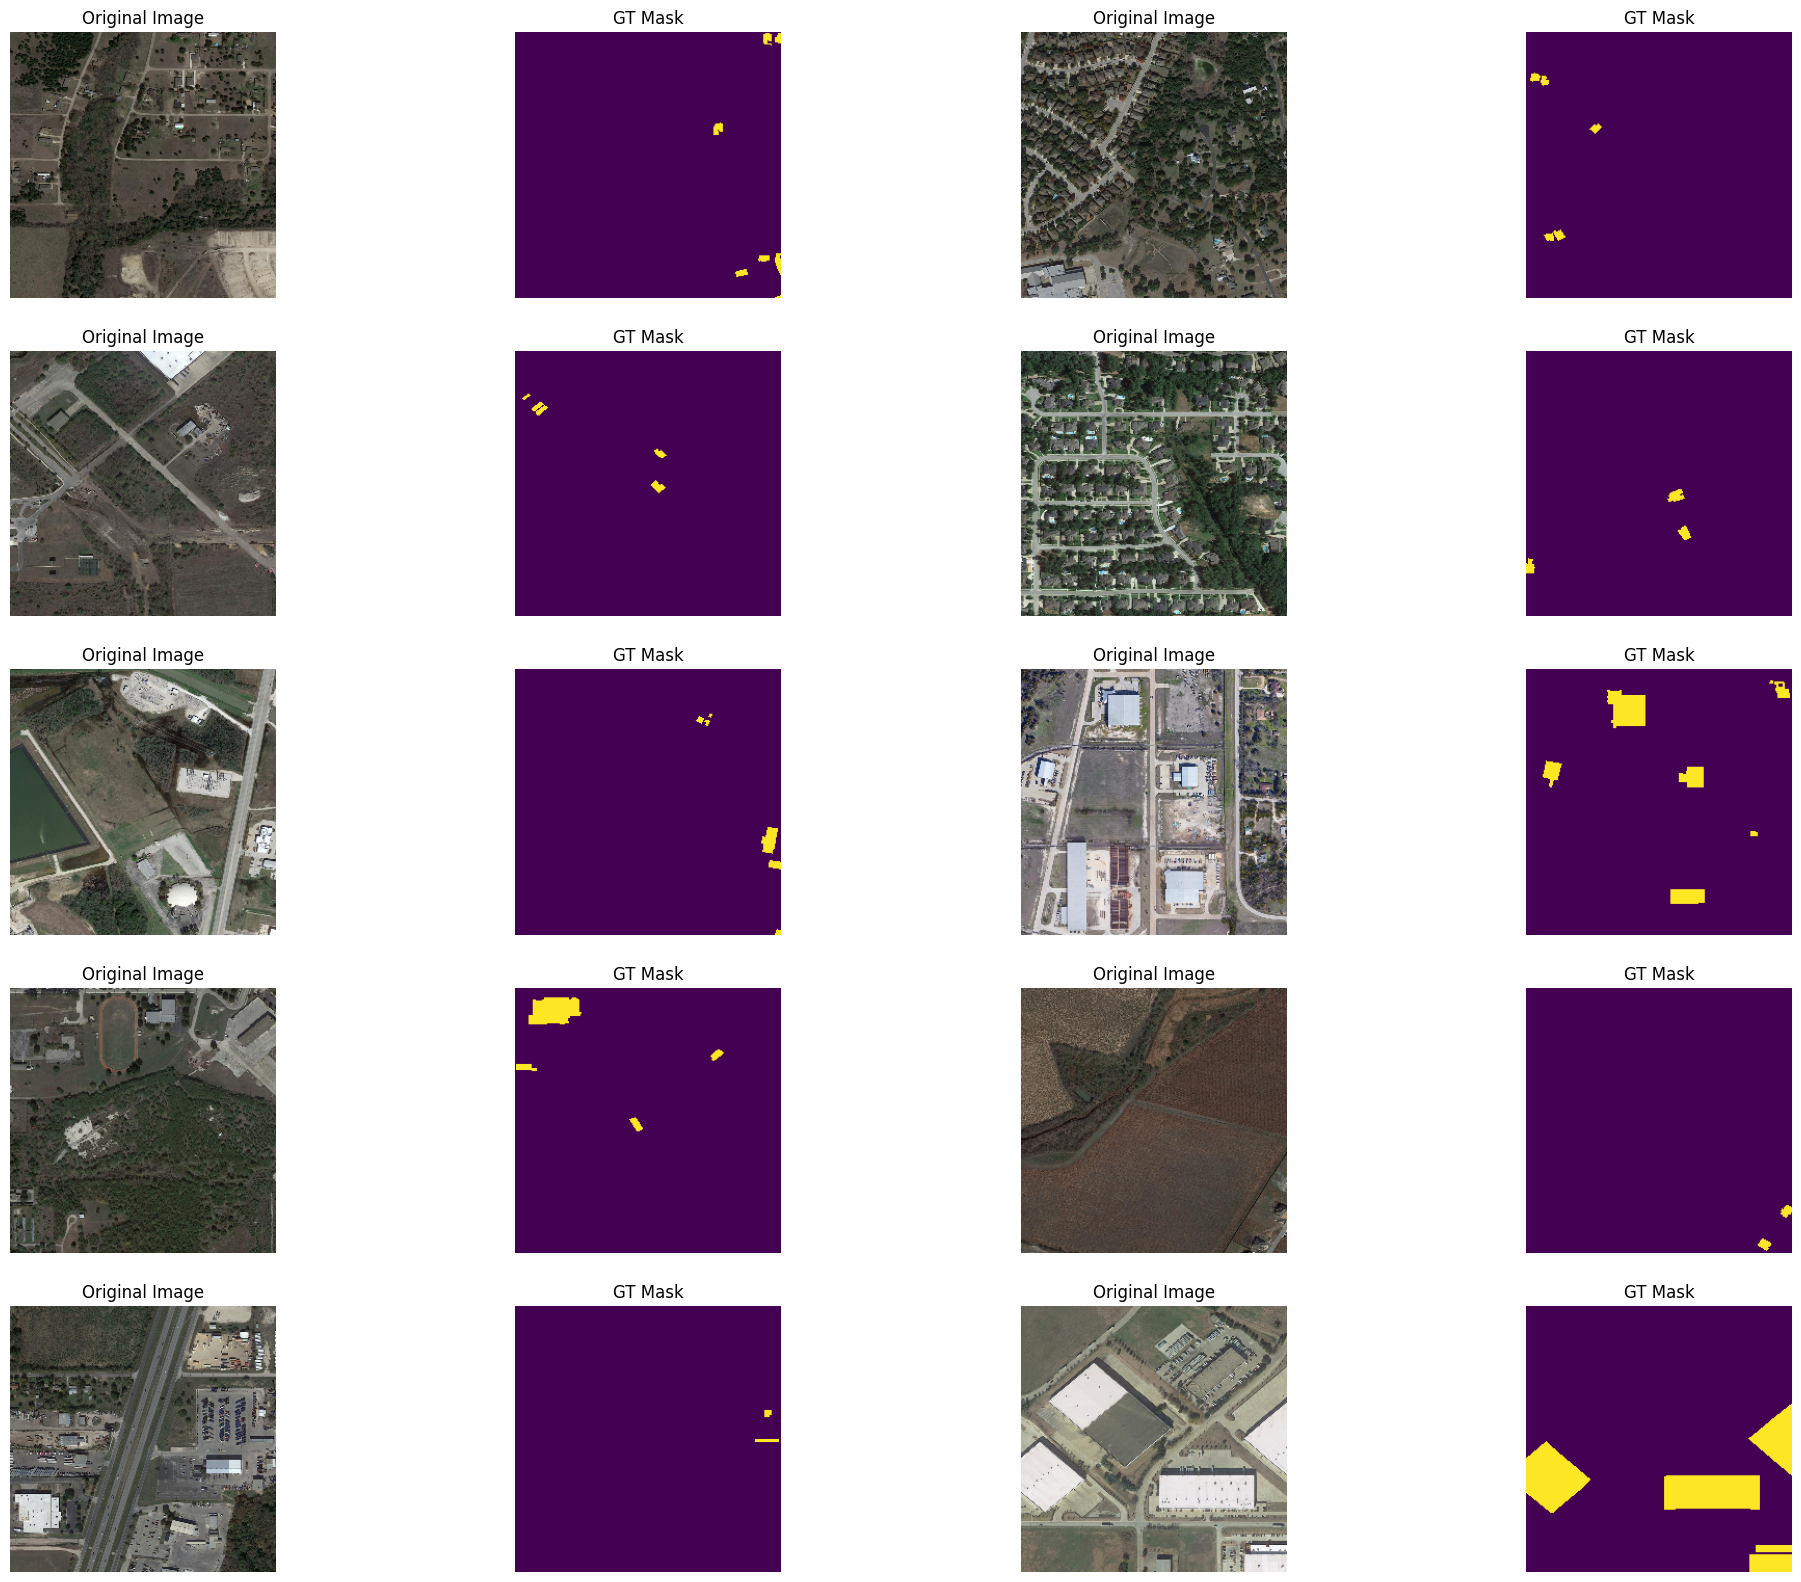

In [13]:
import random
from torchvision import transforms as tfs

def tn_2_np(t):
    invTrans = tfs.Compose([ tfs.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                tfs.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]) ])

    rgb = True if len(t) == 3 else False

    return (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8) if rgb else (t*255).detach().cpu().numpy().astype(np.uint8)

def plot(rows, cols, count, im, gt = None, title = "Original Image"):

    plt.subplot(rows, cols, count)
    plt.imshow(tn_2_np(im.squeeze(0).float())) if gt else plt.imshow(tn_2_np(im.squeeze(0)))
    plt.axis("off"); plt.title(title)

    return count + 1

def visualize(ds, n_ims):

    plt.figure(figsize = (25, 20))
    rows = n_ims // 4; cols = n_ims // rows
    count = 1
    indices = [random.randint(0, len(ds) - 1) for _ in range(n_ims)]

    for idx, index in enumerate(indices):

        if count == n_ims + 1: break
        im, gt = ds[index]

        # First Plot
        count = plot(rows, cols, count, im = im)

        # Second Plot
        count = plot(rows, cols, count, im = gt, gt = True, title = "GT Mask")

visualize(test_dl.dataset, n_ims = 20)

**Train Setup and Evaluation Metrics**

In [14]:
!pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp, time
from tqdm import tqdm
from torch.nn import functional as F

model = smp.DeepLabV3Plus(classes = n_cls)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 3e-4)

class Metrics():

    def __init__(self, pred, gt, loss_fn, eps = 1e-10, n_cls = 2):

        self.pred, self.gt = torch.argmax(F.softmax(pred, dim=1), dim = 1), gt # (batch, width, height)
        self.loss_fn, self.eps, self.n_cls, self.pred_ = loss_fn, eps, n_cls, pred

    def to_contiguous(self, inp): return inp.contiguous().view(-1)

    def PA(self):

        with torch.no_grad():
            match = torch.eq(self.pred, self.gt).int()

        return float(match.sum()) / float(match.numel())

    def mIoU(self):

        with torch.no_grad():
            # self.gt = torch.argmax(self.gt, dim = 1)

            pred, gt = self.to_contiguous(self.pred), self.to_contiguous(self.gt)

            iou_per_class = []

            for c in range(self.n_cls):

                match_pred = pred == c
                match_gt   = gt == c

                if match_gt.long().sum().item() == 0: iou_per_class.append(np.nan)

                else:

                    intersect = torch.logical_and(match_pred, match_gt).sum().float().item()
                    union = torch.logical_or(match_pred, match_gt).sum().float().item()

                    iou = (intersect + self.eps) / (union + self.eps)
                    iou_per_class.append(iou)

            return np.nanmean(iou_per_class)

    def loss(self): return self.loss_fn(self.pred_, self.gt.long())

def tic_toc(start_time = None): return time.time() if start_time == None else time.time() - start_time

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.3 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [15]:
import torch
save_prefix = "levir"
def train(model, tr_dl, val_dl, loss_fn, opt, device, epochs, save_prefix, threshold = 0.01, save_path = "saved_models"):

    tr_loss, tr_pa, tr_iou = [], [], []
    val_loss, val_pa, val_iou = [], [], []
    tr_len, val_len = len(tr_dl), len(val_dl)
    best_loss, decrease, not_improve, early_stop_threshold = np.inf, 1, 0, 5
    os.makedirs(save_path, exist_ok = True)

    model.to(device)
    train_start = tic_toc()
    print("Start training process...")

    for epoch in range(1, epochs + 1):
        tic = tic_toc()
        tr_loss_, tr_iou_, tr_pa_ = 0, 0, 0

        model.train()
        print(f"Epoch {epoch} train process is started...")
        for idx, batch in enumerate(tqdm(tr_dl)):

            ims, gts = batch
            ims, gts = ims.to(device), gts.to(device)

            preds = model(ims)

            met = Metrics(preds, gts, loss_fn, n_cls = n_cls)
            loss_ = met.loss()

            tr_iou_ += met.mIoU()

            tr_pa_ += met.PA()
            tr_loss_ += loss_.item()

            loss_.backward()
            opt.step()
            opt.zero_grad()

        print(f"Epoch {epoch} validation process is started...")
        model.eval()
        val_loss_, val_iou_, val_pa_ = 0, 0, 0

        with torch.no_grad():
            for idx, batch in enumerate(tqdm(val_dl)):

                ims, gts = batch
                ims, gts = ims.to(device), gts.to(device)

                preds = model(ims)

                met = Metrics(preds, gts, loss_fn, n_cls = n_cls)

                val_loss_ += met.loss().item()
                val_iou_ += met.mIoU()
                val_pa_ += met.PA()


        print(f"Epoch {epoch} train process is completed.")

        tr_loss_ /= tr_len
        tr_iou_ /= tr_len
        tr_pa_ /= tr_len

        val_loss_ /= val_len
        val_iou_ /=  val_len
        val_pa_ /=   val_len

        print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print(f"\nEpoch {epoch} train process results: \n")
        print(f"Train Time         -> {tic_toc(tic):.3f} secs")
        print(f"Train Loss         -> {tr_loss_:.3f}")
        print(f"Train PA           -> {tr_pa_:.3f}")
        print(f"Train IoU          -> {tr_iou_:.3f}")
        print(f"Validation Loss    -> {val_loss_:.3f}")
        print(f"Validation PA      -> {val_pa_:.3f}")
        print(f"Validation IoU     -> {val_iou_:.3f}\n")

        tr_loss.append(tr_loss_)
        tr_iou.append(tr_iou_)
        tr_pa.append(tr_pa_)

        val_loss.append(val_loss_)
        val_iou.append(val_iou_)
        val_pa.append(val_pa_)

        if (val_loss_ + threshold) < best_loss:
            print(f"Loss decreased from {best_loss:.3f} to {val_loss_:.3f}!")
            best_loss = val_loss_
            decrease += 1
            print("Saving the model with the best loss value...")
            torch.save(model, f"{save_path}/{save_prefix}_best_model.pt")

        else:
            not_improve += 1
            best_loss = val_loss_
            print(f"Loss did not decrease for {not_improve} epoch(s)!")
            if not_improve == early_stop_threshold:
                print(f"Stopping training process becuase loss value did not decrease for {early_stop_threshold} epochs!")
                break
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")

    print(f"Train process is completed in {(tic_toc(train_start)) / 60:.3f} minutes.")

    return {"tr_loss": tr_loss, "tr_iou": tr_iou, "tr_pa": tr_pa,
            "val_loss": val_loss, "val_iou": val_iou, "val_pa" : val_pa}

device = "cuda" if torch.cuda.is_available() else "cpu"

history = train(model = model, tr_dl = tr_dl, val_dl = val_dl,
                 loss_fn = loss_fn, opt = optimizer, device = device,
                 epochs = 20, save_prefix = save_prefix)

Start training process...
Epoch 1 train process is started...


  0%|          | 0/36 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 36/36 [00:22<00:00,  1.62it/s]


Epoch 1 validation process is started...


100%|██████████| 4/4 [00:02<00:00,  1.37it/s]


Epoch 1 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 1 train process results: 

Train Time         -> 25.206 secs
Train Loss         -> 0.364
Train PA           -> 0.867
Train IoU          -> 0.464
Validation Loss    -> 0.384
Validation PA      -> 0.903
Validation IoU     -> 0.599

Loss decreased from inf to 0.384!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 train process is started...


100%|██████████| 36/36 [00:20<00:00,  1.73it/s]


Epoch 2 validation process is started...


100%|██████████| 4/4 [00:03<00:00,  1.12it/s]


Epoch 2 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 train process results: 

Train Time         -> 24.372 secs
Train Loss         -> 0.130
Train PA           -> 0.960
Train IoU          -> 0.598
Validation Loss    -> 0.134
Validation PA      -> 0.957
Validation IoU     -> 0.668

Loss decreased from 0.384 to 0.134!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 train process is started...


100%|██████████| 36/36 [00:20<00:00,  1.74it/s]


Epoch 3 validation process is started...


100%|██████████| 4/4 [00:02<00:00,  1.45it/s]


Epoch 3 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 train process results: 

Train Time         -> 23.508 secs
Train Loss         -> 0.104
Train PA           -> 0.964
Train IoU          -> 0.652
Validation Loss    -> 0.119
Validation PA      -> 0.953
Validation IoU     -> 0.572

Loss decreased from 0.134 to 0.119!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 train process is started...


100%|██████████| 36/36 [00:21<00:00,  1.71it/s]


Epoch 4 validation process is started...


100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


Epoch 4 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 train process results: 

Train Time         -> 23.548 secs
Train Loss         -> 0.092
Train PA           -> 0.966
Train IoU          -> 0.677
Validation Loss    -> 0.113
Validation PA      -> 0.955
Validation IoU     -> 0.596

Loss did not decrease for 1 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 train process is started...


100%|██████████| 36/36 [00:21<00:00,  1.67it/s]


Epoch 5 validation process is started...


100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


Epoch 5 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 train process results: 

Train Time         -> 24.043 secs
Train Loss         -> 0.091
Train PA           -> 0.965
Train IoU          -> 0.674
Validation Loss    -> 0.106
Validation PA      -> 0.957
Validation IoU     -> 0.637

Loss did not decrease for 2 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 6 train process is started...


100%|██████████| 36/36 [00:21<00:00,  1.64it/s]


Epoch 6 validation process is started...


100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


Epoch 6 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 6 train process results: 

Train Time         -> 24.371 secs
Train Loss         -> 0.083
Train PA           -> 0.968
Train IoU          -> 0.698
Validation Loss    -> 0.095
Validation PA      -> 0.961
Validation IoU     -> 0.687

Loss decreased from 0.106 to 0.095!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 7 train process is started...


100%|██████████| 36/36 [00:21<00:00,  1.64it/s]


Epoch 7 validation process is started...


100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


Epoch 7 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 7 train process results: 

Train Time         -> 24.592 secs
Train Loss         -> 0.078
Train PA           -> 0.970
Train IoU          -> 0.717
Validation Loss    -> 0.095
Validation PA      -> 0.961
Validation IoU     -> 0.679

Loss did not decrease for 3 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 8 train process is started...


100%|██████████| 36/36 [00:22<00:00,  1.61it/s]


Epoch 8 validation process is started...


100%|██████████| 4/4 [00:02<00:00,  1.67it/s]


Epoch 8 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 8 train process results: 

Train Time         -> 24.702 secs
Train Loss         -> 0.077
Train PA           -> 0.970
Train IoU          -> 0.718
Validation Loss    -> 0.102
Validation PA      -> 0.958
Validation IoU     -> 0.638

Loss did not decrease for 4 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 9 train process is started...


100%|██████████| 36/36 [00:22<00:00,  1.63it/s]


Epoch 9 validation process is started...


100%|██████████| 4/4 [00:02<00:00,  1.63it/s]

Epoch 9 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 9 train process results: 

Train Time         -> 24.600 secs
Train Loss         -> 0.073
Train PA           -> 0.971
Train IoU          -> 0.729
Validation Loss    -> 0.094
Validation PA      -> 0.961
Validation IoU     -> 0.708

Loss did not decrease for 5 epoch(s)!
Stopping training process becuase loss value did not decrease for 5 epochs!
Train process is completed in 3.666 minutes.


**AI Model train and Validation **

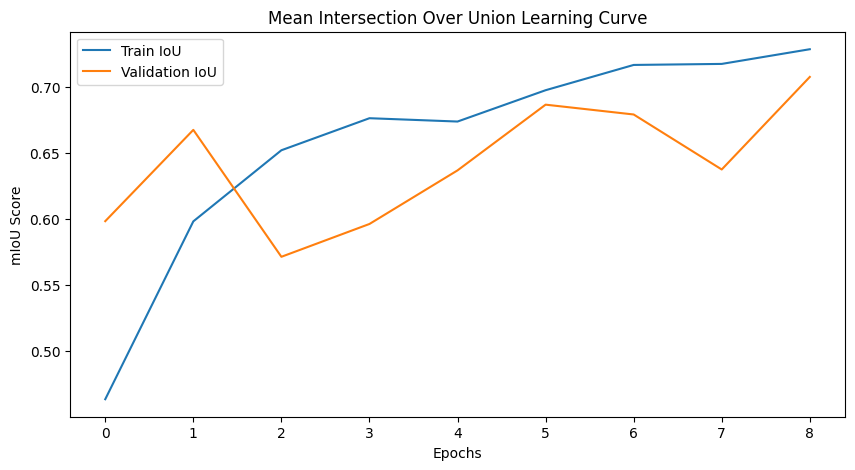

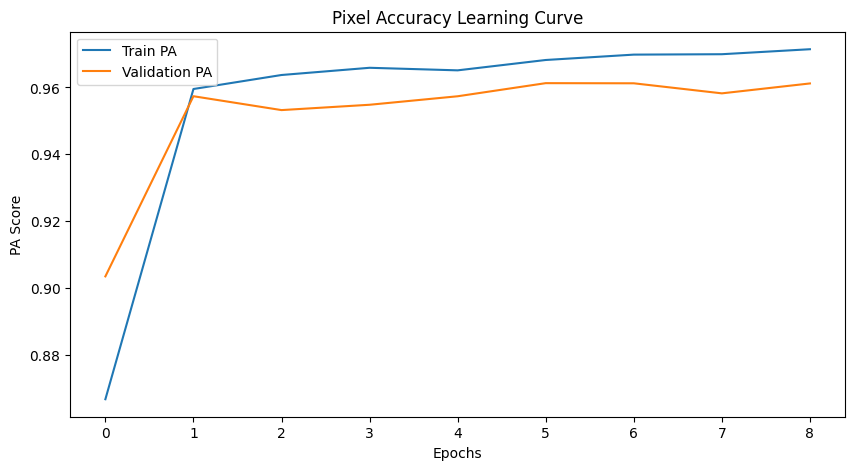

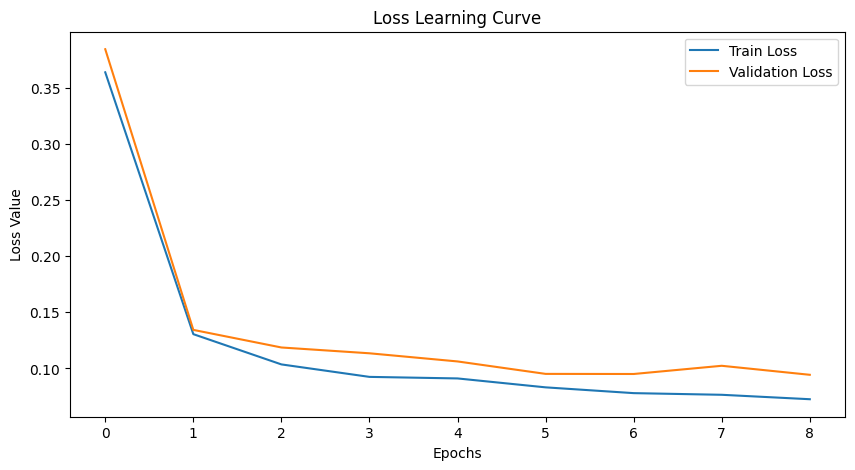

In [16]:
class Plot():

    def __init__(self, res):

        self.res = res

        self.visualize(metric1 = "tr_iou", metric2 = "val_iou", label1 = "Train IoU",
                  label2 = "Validation IoU", title = "Mean Intersection Over Union Learning Curve", ylabel = "mIoU Score")

        self.visualize(metric1 = "tr_pa", metric2 = "val_pa", label1 = "Train PA",
                  label2 = "Validation PA", title = "Pixel Accuracy Learning Curve", ylabel = "PA Score")

        self.visualize(metric1 = "tr_loss", metric2 = "val_loss", label1 = "Train Loss",
                  label2 = "Validation Loss", title = "Loss Learning Curve", ylabel = "Loss Value")


    def plot(self, metric, label): plt.plot(self.res[metric], label = label)

    def decorate(self, ylabel, title): plt.title(title); plt.xlabel("Epochs"); plt.ylabel(ylabel); plt.legend(); plt.show()

    def visualize(self, metric1, metric2, label1, label2, title, ylabel):

        plt.figure(figsize=(10, 5))
        self.plot(metric1, label1); self.plot(metric2, label2)
        self.decorate(ylabel, title)

Plot(history)

**Learning Curves**

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


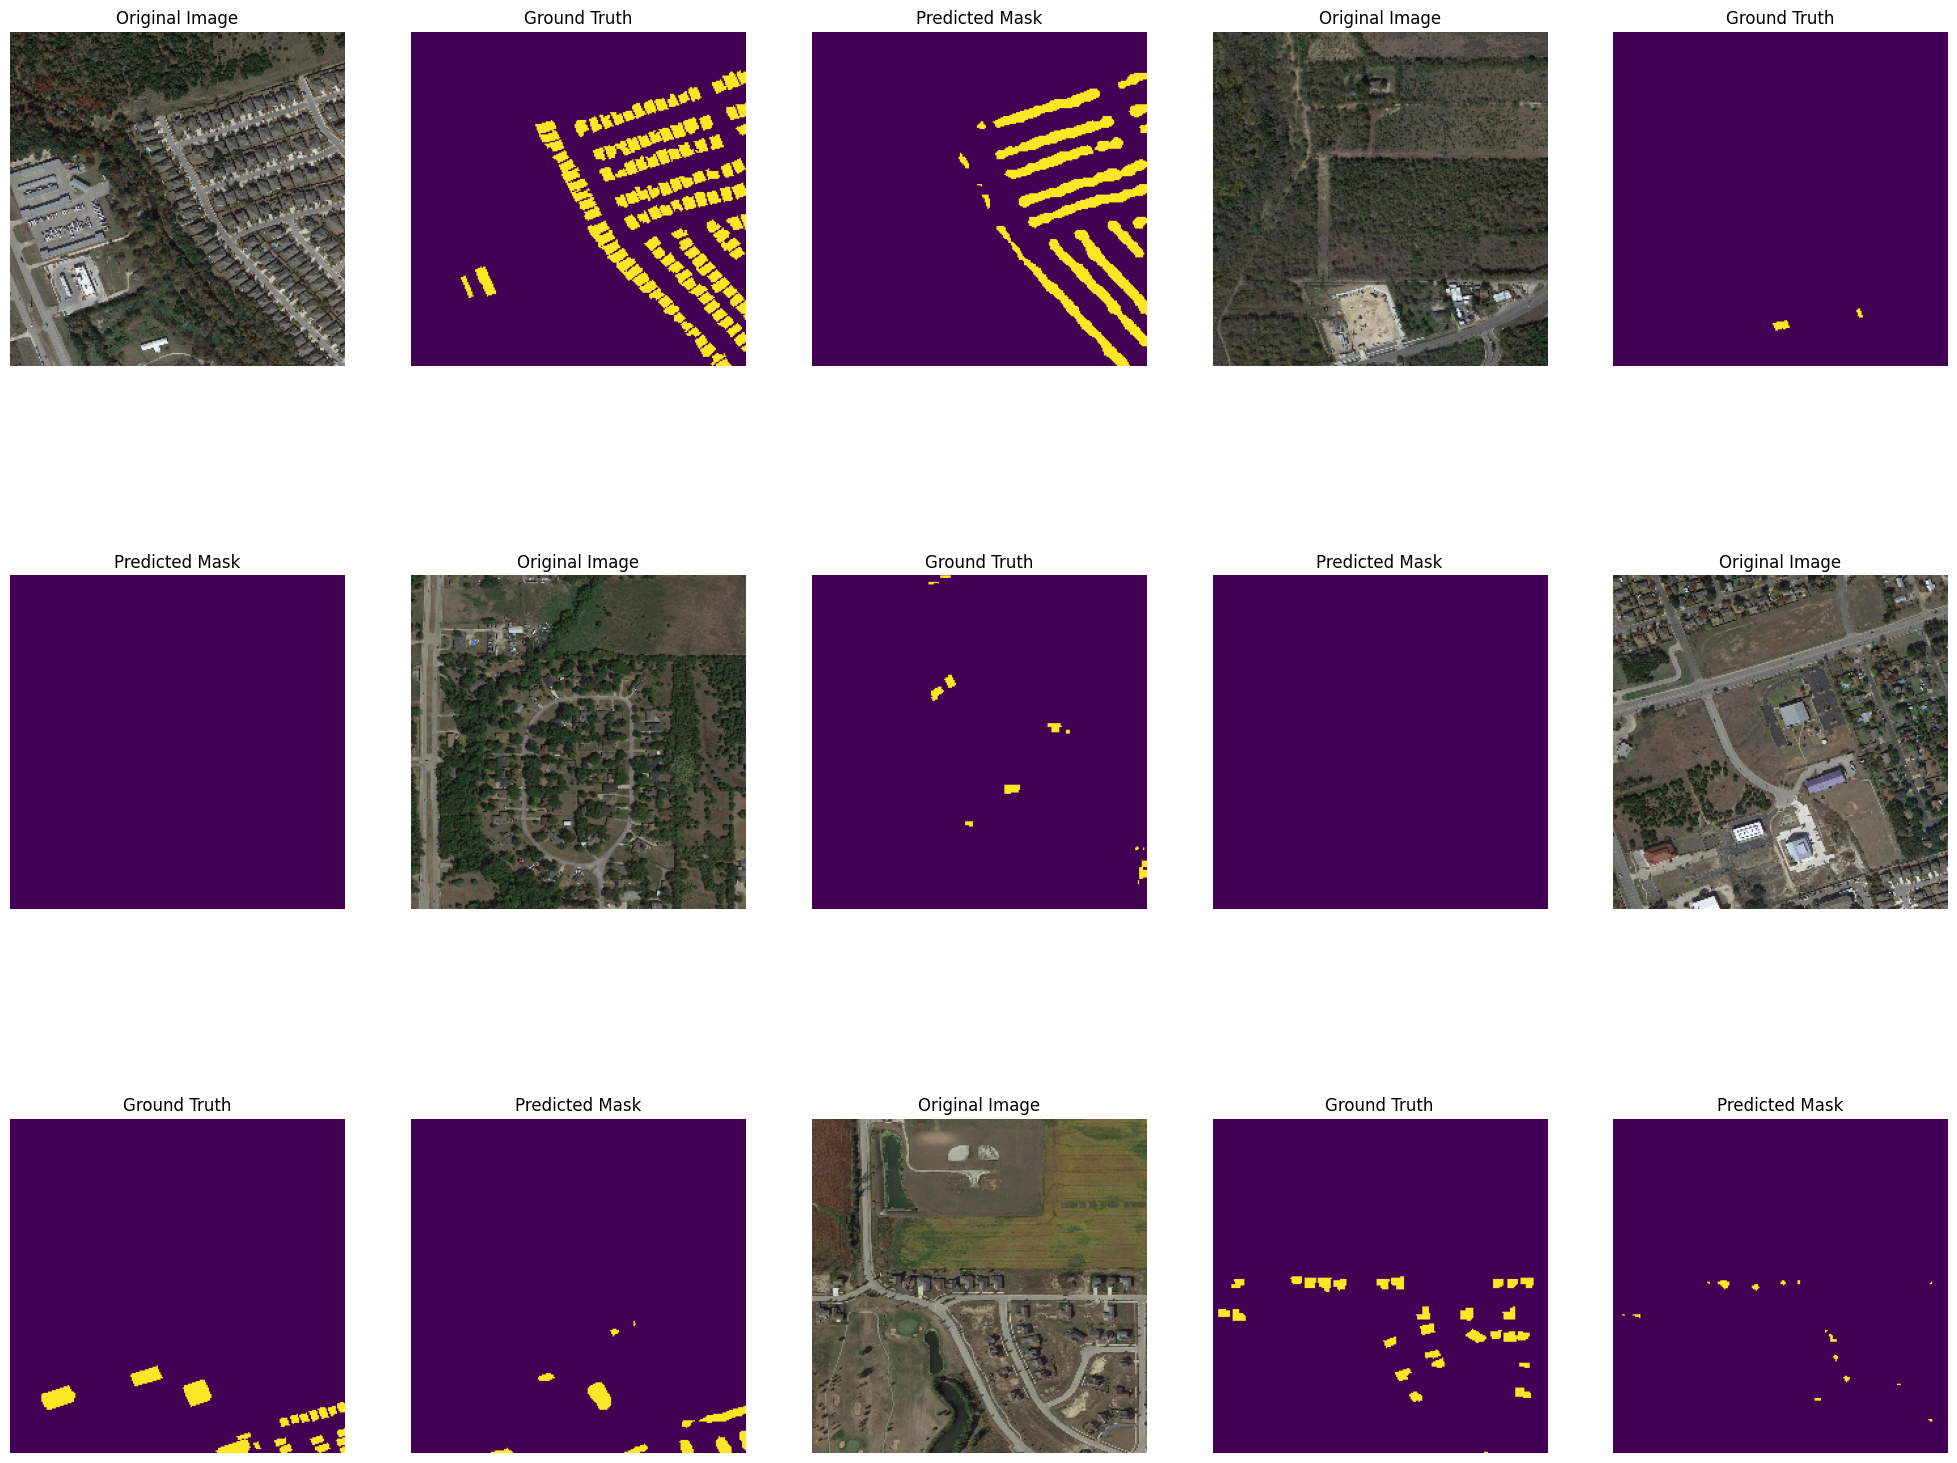

In [19]:
def inference(dl, model, device, n_ims = 15):

    cols = n_ims // 3; rows = n_ims // cols

    count = 1
    ims, gts, preds = [], [], []
    for idx, data in enumerate(dl):
        im, gt = data

        # Get predicted mask
        with torch.no_grad(): pred = torch.argmax(model(im.to(device)), dim = 1)
        ims.append(im); gts.append(gt); preds.append(pred)

    plt.figure(figsize = (25, 20))
    for idx, (im, gt, pred) in enumerate(zip(ims, gts, preds)):
        if idx == cols: break

        # First plot
        count = plot(rows, cols, count, im)

        # Second plot
        count = plot(rows, cols, count, im = gt.squeeze(0), gt = True, title = "Ground Truth")

        # Third plot
        count = plot(rows, cols, count, im = pred, title = "Predicted Mask")

model = torch.load(f"saved_models/{save_prefix}_best_model.pt", weights_only=False)
inference(test_dl, model = model, device = device)

**inference and Ai model Performance**